<a href="https://colab.research.google.com/github/WaznyKamo/CDR_Stock_Price_Prediction_Using_LSTM_Deep_Learning_Network/blob/main/CDR_Stock_Price_Prediction_Using_LSTM_Deep_Learning_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Prediction of stock prices on example of CD PROJEKT RED

Daily data used in the notebook comes from: https://stooq.pl/q/d/?s=cdr
In order to load data one should download a file, load it into Google Drive and change the mounting point path

The program will ask for logging in into your google account in order to mount data from the Drive to Colab.


In [60]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)


Mounted at /content/drive


In [61]:
import pandas as pd
import numpy as np

daily_data = pd.read_csv("/content/drive/MyDrive/Praca magisterska/data/cdr_d.csv")

daily_data.head()

,Data,Otwarcie,Najwyzszy,Najnizszy,Zamkniecie,Wolumen
0,1994-08-02,8.2789,8.2789,8.2789,8.2789,347109.0
1,1994-08-03,9.0931,9.0931,9.0931,9.0931,325196.0
2,1994-08-04,9.9950,9.9950,9.9950,9.9950,355499.0
3,1994-08-08,9.0931,9.0931,9.0931,9.0931,263619.0
4,1994-08-09,10.7320,10.7320,10.7320,10.7320,135441.0


In [62]:
daily_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6556 entries, 0 to 6555
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Data        6556 non-null   object 
 1   Otwarcie    6556 non-null   float64
 2   Najwyzszy   6556 non-null   float64
 3   Najnizszy   6556 non-null   float64
 4   Zamkniecie  6556 non-null   float64
 5   Wolumen     6555 non-null   float64
dtypes: float64(5), object(1)
memory usage: 307.4+ KB


In [63]:
null_columns = daily_data.columns[daily_data.isnull().any()]
daily_data.isnull().sum()

Data          0
Otwarcie      0
Najwyzszy     0
Najnizszy     0
Zamkniecie    0
Wolumen       1
dtype: int64

In [64]:
daily_data['Data'] = pd.to_datetime(daily_data.Data)

In [65]:
print(daily_data[daily_data["Wolumen"].isnull()]) # row with a null value

         Data  Otwarcie  Najwyzszy  Najnizszy  Zamkniecie  Wolumen
79 1994-12-08    5.1204     5.1204     5.1204      5.1204      NaN


In given dataset on 1994-12-08 the Wolumen value is null. According to https://www.biznesradar.pl/notowania-historyczne/CD-PROJEKT,130 it should be 0, so the value has to be overwritten.



In [66]:
daily_data.fillna(0, inplace=True)
print(daily_data[daily_data["Wolumen"].isnull()])

Empty DataFrame
Columns: [Data, Otwarcie, Najwyzszy, Najnizszy, Zamkniecie, Wolumen]
Index: []


In [67]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Candlestick(x=daily_data['Data'],
                                     open=daily_data['Otwarcie'],
                                     high=daily_data['Najwyzszy'],
                                     low=daily_data['Najnizszy'],
                                     close=daily_data['Zamkniecie'])])

fig.update_layout(title='Stock price of CD Projekt',
                  yaxis_title='Price',
                  xaxis_title='Date')
fig.show()

# slider below the plot can be used for narrowing the dates

# Preparation of data for prediction



In [68]:
from sklearn.preprocessing import MinMaxScaler

# expected input data shape [number of training examples, number of data in single example (days considered for prediction), number of features]
def preprocess_scaled_data(data):
  dataset = np.transpose([data['Otwarcie'], data['Zamkniecie'], data['Najnizszy'], data['Najwyzszy'], data['Wolumen']])

  scaler = MinMaxScaler(feature_range=(0,1))
  scaled_data = scaler.fit_transform(dataset)

  return scaled_data, scaler


In [69]:
dataset, scaler = preprocess_scaled_data(daily_data)
print('dataset shape: ' + str(dataset.shape))

# using data from last 30 days for validation, rest for training
training_data = dataset[:-30,:]

x_train = []
y_train = []
x_valid = []
y_valid = []

# predicting prices from data from last 60 days
for i in range(60, training_data.shape[0]):
  x_train.append(training_data[i-60:i, :])
  y_train.append(training_data[i,:])

x_train, y_train = np.array(x_train), np.array(y_train)

print('x_train shape: ' + str(x_train.shape))
print('y_train shape: ' + str(y_train.shape))

for i in range(dataset.shape[0] - 30, dataset.shape[0]):
  x_valid.append(dataset[i-60:i, :])
  y_valid.append(dataset[i,:])

x_valid, y_valid = np.array(x_valid), np.array(y_valid)

print('x_valid shape: ' + str(x_valid.shape))
print('y_valid shape: ' + str(y_valid.shape))

dataset shape: (6556, 5)
x_train shape: (6466, 60, 5)
y_train shape: (6466, 5)
x_valid shape: (30, 60, 5)
y_valid shape: (30, 5)


## Defining the LSTM Model

In [70]:
import numpy as np
import tensorflow as tf
from keras.models import Model
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Lambda, Dropout, Conv1D
import matplotlib.pyplot as plt

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               68608     
_________________________________________________________________
dense_2 (Dense)              (None, 30)                3870      
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 155       
Total params: 72,633
Trainable params: 72,633
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
203/203 [==============================] - 3s 7ms/step - loss: 0.0026 - val_loss: 0.0111
Epoch 2/30
203/203 [==============================] - 1s 4ms/step - loss: 4.2539e-04 - val_loss: 0.0084
Epoch 3/30
203/203 [==============================] - 1s 4ms/step - loss: 3.8319e-04 - val_loss: 0.0072
Epoch 4/30
203/203 [==============================] - 1s 5ms/step - loss

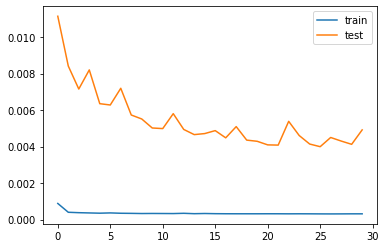

In [71]:

model = Sequential()
model.add(LSTM(128, input_shape=[x_train.shape[1], x_train.shape[2]])) #), return_sequences=True))
#model.add(LSTM(64))
#model.add(Dropout(0.3))
model.add(Dense(30))
model.add(Dense(x_train.shape[2]))

model.summary()

model.compile(loss='mse', optimizer='adam')

history = model.fit(x_train, y_train, epochs=30, validation_data=(x_valid, y_valid))

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [72]:
# Evaluation of the results is made on closing prices - it gives the most information about the usefullness of the model.  Made on the last 30 days of the stock data

predictions = model.predict(x_valid)
predictions = scaler.inverse_transform(predictions)

mae = np.mean(np.abs((predictions[:,1] - scaler.inverse_transform(y_valid)[:,1])))
naive_forcast_difference = [abs(scaler.inverse_transform(y_valid)[i + 1,1] - scaler.inverse_transform(y_valid)[i,1]) for i in range(y_valid.shape[0] - 1)]
naive_forcast_mae = sum(naive_forcast_difference) / len(naive_forcast_difference)
print('Mean absolute error: ' + str(mae))
print('Naive forcast mae: ' + str(naive_forcast_mae))

Mean absolute error: 14.44745402018229
Naive forcast mae: 12.651724137931035


In [73]:
# Comparision of the closing stock prices
inversed_dataset = scaler.inverse_transform(dataset)
print('Ceny zamknięcia: Przewidywana/Rzeczywista/Różnica')
closing_prices = daily_data['Zamkniecie']
for i in range(predictions.shape[0]):
  print(str(round(predictions[i, 1], 1)) + ' / ' + str(daily_data['Zamkniecie'].iloc[-30 + i]) + ' / ' + str(round(predictions[i, 1] - daily_data['Zamkniecie'].iloc[-30 + i], 1)))

Ceny zamknięcia: Przewidywana/Rzeczywista/Różnica
368.4 / 369.6 / -1.2
372.8 / 374.5 / -1.7
379.8 / 368.0 / 11.8
372.6 / 372.2 / 0.4
377.1 / 372.6 / 4.5
381.7 / 371.1 / 10.6
375.0 / 364.0 / 11.0
370.5 / 358.9 / 11.6
368.4 / 362.7 / 5.7
365.1 / 389.5 / -24.4
391.6 / 406.0 / -14.4
411.3 / 425.0 / -13.7
424.1 / 421.0 / 3.1
424.4 / 443.0 / -18.6
443.2 / 425.1 / 18.1
431.0 / 395.0 / 36.0
395.9 / 395.8 / 0.1
402.6 / 362.0 / 40.6
373.5 / 320.5 / 53.0
330.4 / 296.1 / 34.3
284.3 / 300.0 / -15.7
309.4 / 300.0 / 9.4
303.4 / 309.2 / -5.8
316.4 / 271.4 / 45.0
266.8 / 256.0 / 10.8
259.6 / 267.7 / -8.1
274.1 / 269.0 / 5.1
271.8 / 274.0 / -2.2
274.9 / 280.5 / -5.6
285.7 / 274.7 / 11.0


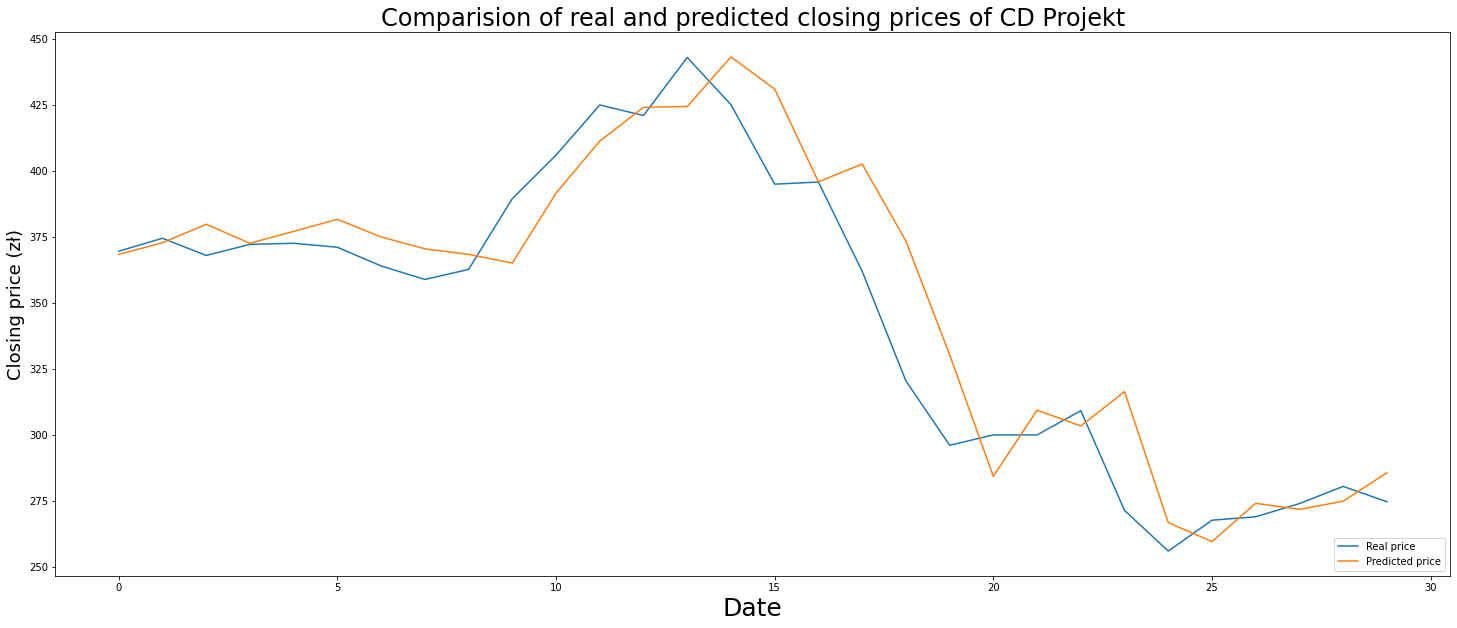

In [84]:
closing_prices = scaler.inverse_transform(dataset)[-30:,1]

predicted_closing_prices = np.round(predictions[:, 1], 1)

plt.figure(figsize=(25,10))
plt.title('Comparision of real and predicted closing prices of CD Projekt', fontsize=24)
plt.xlabel('Date', fontsize=25)
plt.ylabel('Closing price (zł)', fontsize=18)
plt.plot(closing_prices)
plt.plot(predicted_closing_prices)
plt.legend(['Real price',  'Predicted price'], loc='lower right')
plt.show()

# Conclusion:

A single company data is not enough for getting useful predictions from neural network, although, considering small amount of training data, the results are pretty accurate (very close to naive prediction).

Training the neural network on more data (using more companies' data) and using more input features like indicators of technical or fundamental analysis and maybe some external factors might make predictions much better and useful in real world applications.

# Adding technical indicators to the neural network features

In [75]:
daily_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6556 entries, 0 to 6555
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Data        6556 non-null   datetime64[ns]
 1   Otwarcie    6556 non-null   float64       
 2   Najwyzszy   6556 non-null   float64       
 3   Najnizszy   6556 non-null   float64       
 4   Zamkniecie  6556 non-null   float64       
 5   Wolumen     6556 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 307.4 KB


In [76]:
daily_data.head()

,Data,Otwarcie,Najwyzszy,Najnizszy,Zamkniecie,Wolumen
0,1994-08-02,8.2789,8.2789,8.2789,8.2789,347109.0
1,1994-08-03,9.0931,9.0931,9.0931,9.0931,325196.0
2,1994-08-04,9.9950,9.9950,9.9950,9.9950,355499.0
3,1994-08-08,9.0931,9.0931,9.0931,9.0931,263619.0
4,1994-08-09,10.7320,10.7320,10.7320,10.7320,135441.0


Calculating moving averages on closing prices for periods of 10, 30 and 60 days

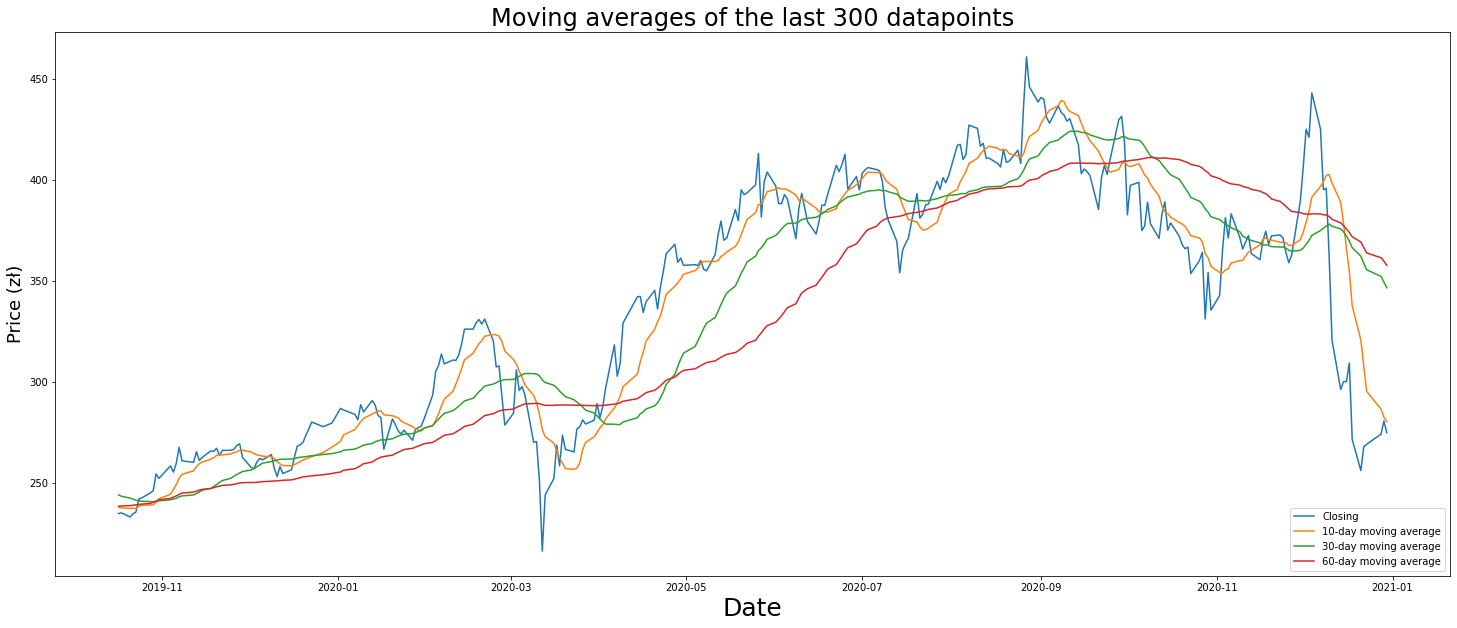

In [83]:

daily_data['MovingAverage10'] = daily_data['Zamkniecie'].rolling(10).mean()
daily_data['MovingAverage30'] = daily_data['Zamkniecie'].rolling(30).mean()
daily_data['MovingAverage60'] = daily_data['Zamkniecie'].rolling(60).mean()

datapoints_to_show = 300

plt.figure(figsize=(25,10))
plt.plot(daily_data['Data'].tail(datapoints_to_show), daily_data[['Zamkniecie', 'MovingAverage10', 'MovingAverage30', 'MovingAverage60']].tail(datapoints_to_show))
plt.title('Moving averages of the last ' + str(datapoints_to_show) + ' datapoints', fontsize=24)
plt.xlabel('Date', fontsize=25)
plt.ylabel('Price (zł)', fontsize=18)
plt.legend(['Closing',  '10-day moving average',  '30-day moving average',  '60-day moving average'], loc='lower right')

Calculating RSI 

In [89]:
period = 10
increase_diffrence, decrease_diffrence = daily_data['Zamkniecie'].diff(), daily_data['Zamkniecie'].diff()

increase_diffrence[increase_diffrence < 0] = 0
decrease_diffrence[decrease_diffrence > 0] = 0
# calculating EWMA (exponential moving average)
roll_increase = increase_diffrence.ewm(span = period).mean()
roll_decrease = decrease_diffrence.abs().ewm(span = period).mean()

RS = roll_increase / roll_decrease

RSI = 100 - (100 / (1 + RS))

daily_data['RSI'] = RSI

Text(0, 0.5, 'RSI')

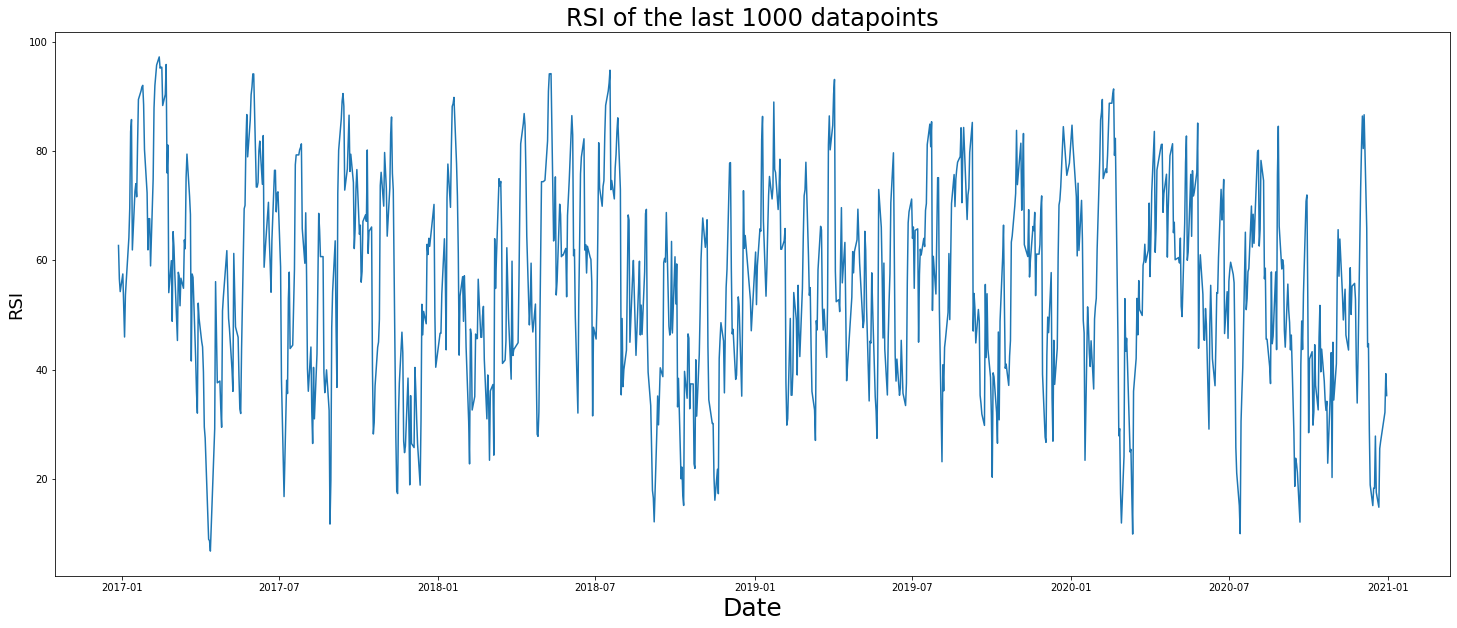

In [98]:
datapoints_to_show = 1000
plt.figure(figsize=(25,10))
plt.plot(daily_data['Data'].tail(datapoints_to_show), daily_data['RSI'].tail(datapoints_to_show))
plt.title('RSI of the last ' + str(datapoints_to_show) + ' datapoints', fontsize=24)
plt.xlabel('Date', fontsize=25)
plt.ylabel('RSI', fontsize=18)
